Hi, This is my first kernel . I've been doing the fastai course and found this dataset. So I decided to practice with a bit.

In [1]:
cp -r /kaggle/input/images /tmp

In [2]:
mv /tmp/images/images/validation/ /tmp/images/images/valid

Importing my packages

In [3]:
import numpy as np
import pandas as pd

from fastai.vision import *
from fastai.widgets import *

In [4]:
path='/tmp/images/images'

Creating a databunch from folder. Fortunately this dataset follows imagenet style, allowing me to just use a factory method.
I'm taking the pictures with size 300X300 (the larger the better, right?)

In [5]:
data=ImageDataBunch.from_folder(path,ds_tfms=get_transforms(),size=300)

Let's see our data now...

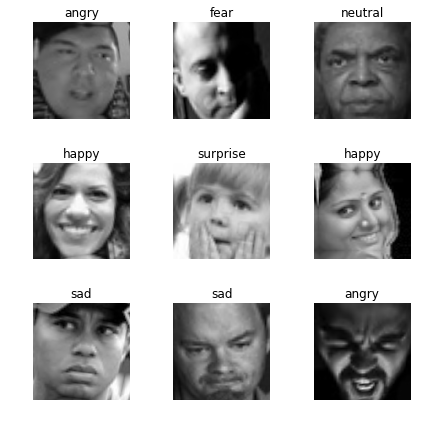

In [6]:
data.show_batch(rows=3,figsize=(6,6))

I'm useing a resnet50 model and error_rate as my metric.
The error rate is quite large. Nearly 40% error is not very impressive, given that even the model is usually very accurate.

In [7]:
learner=cnn_learner(data,models.resnet50,metrics=error_rate)
learner.fit_one_cycle(4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 95968010.46it/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.566590,1.395254,0.542598,05:46
1,1.298507,1.168207,0.445089,05:35
2,1.167168,1.086500,0.417775,05:35
3,1.106306,1.054764,0.399802,05:33


So I decided to fine tune the learning rate for my model with lr_find(). Might help minimizing the error rate. 

In [8]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


It seems my model performs worse after the learning rate goes above 1e-3. Also we can see a consistance downward slope of loss from 1e-5 to 1e-3. This should be our learning rate range.

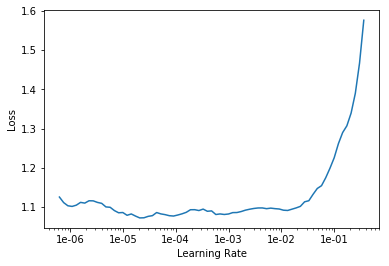

In [9]:
learner.recorder.plot()

So I unfreeze the model to train all of my layers.

In [10]:
learner.unfreeze()

Using the optimal learning rate and fitting again.

In [11]:
learner.fit_one_cycle(4,max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.055934,0.998952,0.374752,05:51
1,0.980536,0.924010,0.345033,05:52
2,0.864843,0.844262,0.314605,05:50
3,0.725639,0.820274,0.298613,05:50


This error_rate is better than before, but the improvement is not significant. At this point I think it's safe to assume that the dataset might have some bad labels and noise. 

In [12]:
interp=ClassificationInterpretation.from_learner(learner)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


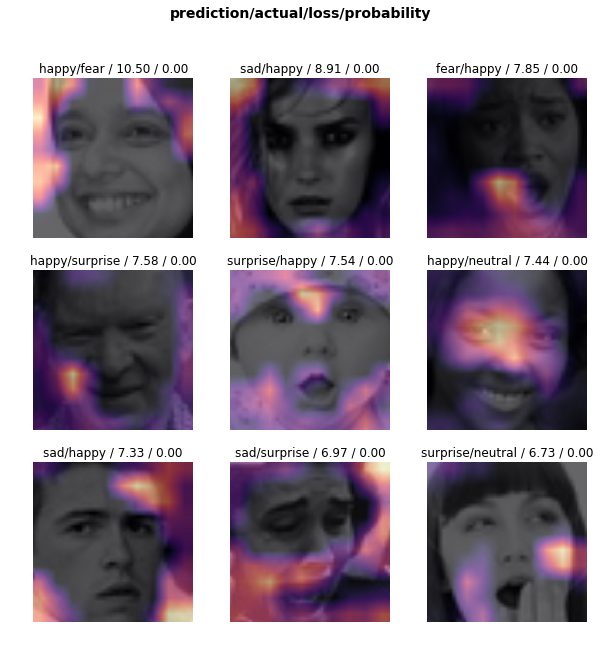

In [13]:
interp.plot_top_losses(9,figsize=(10,10))

It is pretty obvious some instances have been missclassified in the dataset. 

In [14]:
interp.most_confused(min_val=10)

[('sad', 'neutral', 208),
 ('fear', 'sad', 191),
 ('neutral', 'sad', 152),
 ('fear', 'angry', 136),
 ('angry', 'sad', 127),
 ('sad', 'fear', 121),
 ('angry', 'neutral', 105),
 ('sad', 'angry', 103),
 ('fear', 'neutral', 102),
 ('happy', 'neutral', 86),
 ('fear', 'surprise', 79),
 ('neutral', 'happy', 79),
 ('surprise', 'fear', 75),
 ('angry', 'fear', 66),
 ('neutral', 'angry', 57),
 ('surprise', 'happy', 48),
 ('neutral', 'fear', 41),
 ('happy', 'sad', 37),
 ('surprise', 'neutral', 35),
 ('happy', 'surprise', 30),
 ('sad', 'happy', 29),
 ('fear', 'happy', 28),
 ('disgust', 'angry', 26),
 ('angry', 'happy', 23),
 ('happy', 'fear', 23),
 ('happy', 'angry', 18),
 ('angry', 'surprise', 17),
 ('surprise', 'angry', 13),
 ('neutral', 'surprise', 12)]

It would be better to fix some of these labels myself. From both training and testing set.

In [15]:
ds, idxs = DatasetFormatter().from_toplosses(learner, ds_type=DatasetType.Valid)
ImageCleaner(ds,idxs,path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [16]:
ds, idxs = DatasetFormatter().from_toplosses(learner, ds_type=DatasetType.Train)
ImageCleaner(ds,idxs,path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

After cleaning up as much as we can, let's fit the model again.

In [17]:
learner.fit_one_cycle(4,max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.777298,0.901321,0.323946,06:07
1,0.829358,0.888748,0.319417,06:02
2,0.683398,0.814459,0.287574,06:03
3,0.545994,0.816522,0.283187,06:05


As we can see, error_rate was reduced 10%.
I guess this is the best we can expect from a noisy dataset. 
We could spend some more time with cleaning the Training set, improving performance significantly.